# Using k-means clustering for LIDs allocation

## Introduction
Previous research states that aggregating LIDs is a good strategy to reduce runoff and Combined Sewer Overflows.
In this document we will exploite the k-means clustering algorithm to test wether aggregation increase the performance of Pervious Pavements to reduce CSO.

### Step 1: Cluster the subcatchments by location
We need the set of coordinates for each subcatchment

In [136]:
#load required packages
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
global str
import os
from pyswmm import Simulation, Nodes, LidControls, Subcatchments, RainGages  

In [2]:
#function that creates clusters with the subcatchments
def kmeans_clusters(data,num_clusters):
    #data containing coordinates
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(data)
    return kmeans

In [3]:
#Create clusters from PP coordinates
#Load the text file contains the xy coordinates of all the subcatchments.
#We are interested in "Parking" and "SAimp"
#Define the number of clusters, observe that 'clusters_set' is a list, hence we can simultaneously create different number of clusters for testing.
#For illustration, we will only show a 100 clusters

clusters_set=[100]#number of clusters
#'Parking_SAimp_coord.txt'-all Subcatchments
#CSO014_ParkingSAimp_coord.txt- CSO014 ONLY

#Read the file with pandas and reassign the index with the subcatchment name
data_original= pd.read_csv('../STEP1/CSO014_ParkingSAimp_coord.txt',sep='\t') #read the original file
data_original=data_original.set_index('NAME')


#Create clusters and add a column to the original dataset
for i in clusters_set: 
    KMEANS=kmeans_clusters(data_original,i) #object that the function kmeans_clusters returns
    centers=KMEANS.cluster_centers_ #extract the cluster centers
    vector= np.expand_dims(KMEANS.labels_, axis=2) #extract the labels of each point
    data_w_clusters=np.append(data_original,vector,axis=1)

#convert into df again
data_w_clusters= pd.DataFrame(data_w_clusters, columns=['CX','CY','Cluster'], index=data_original.index)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [4]:
###Print subcatchments with clusters
file1=open("../STEP1/CSO014cluster.dat","w")
data_w_clusters.to_string(file1)
file1.close()

###Print cluster's centroids
df_centers = pd.DataFrame(centers,columns=["X_CENTROID","Y_CENTROID"])
df_centers
file2=open("CSO014clusterCENTERS.dat","w")
df_centers.to_string(file2)
file2.close()

### Step 2: Create scenarios for Porous Pavement location based on "aggregation" and "distance from outfall"
Once we have aggregated the subcatchments with k-means (Step 1), we need to calculate the distance of each subcatchment to the outfall. Using this information we will divide the case study area into sectors, which will allow us determine whether the distance to the outlet plays a relevant role in the CSO reduction.
The Figure below shows the result of clustering the `n=100` subcatchments; each color represents a cluster. The red large dot in the south-west of the subcatchment is the outfall.

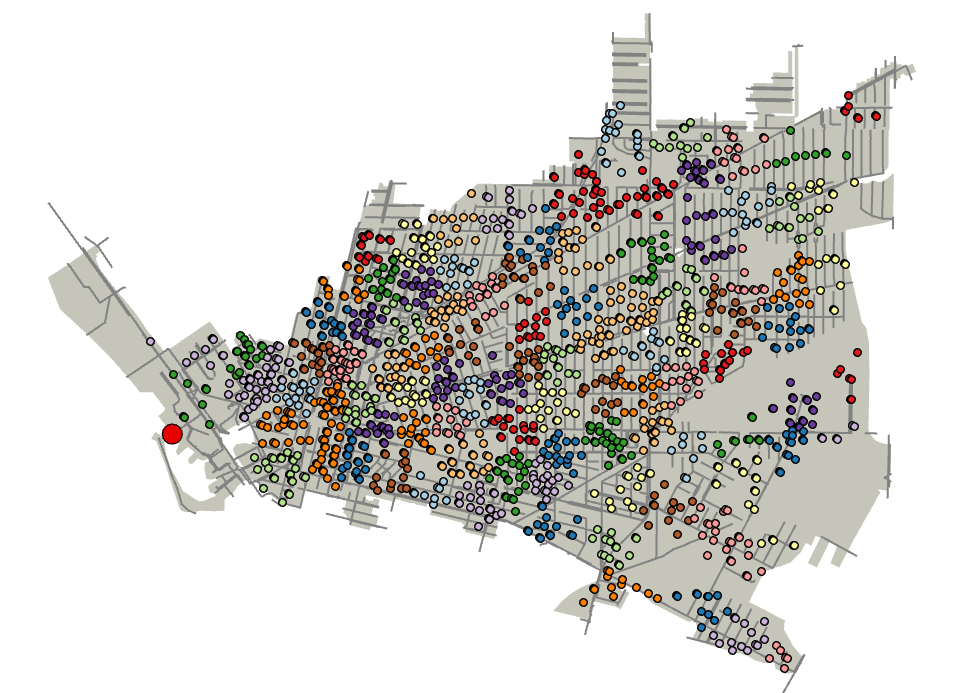

In [5]:
from IPython.display import Image
Image(filename='clusters_outfall.png', width=700)

The distance of each subcatchment to the outfall was calculated using the `Nearest` tool in ArcGis Pro. But any other software for spatial analysis can be used instead. The following figure shows the distribution of the distance for the subcatchments, by cluster. We will use the quartiles of the whole dataset to sectorize the subcatchment into upstream middle-upstream, middle-downstream, and downstream.

Downstream: <= first quantile (25th percentile)
Middle-downstream: <= median
Middle-upstream: <= third quantile (75th percentile)
Upstream: > third quantile (75th percentile)

Text(0, 0.5, 'Distance (ft)')

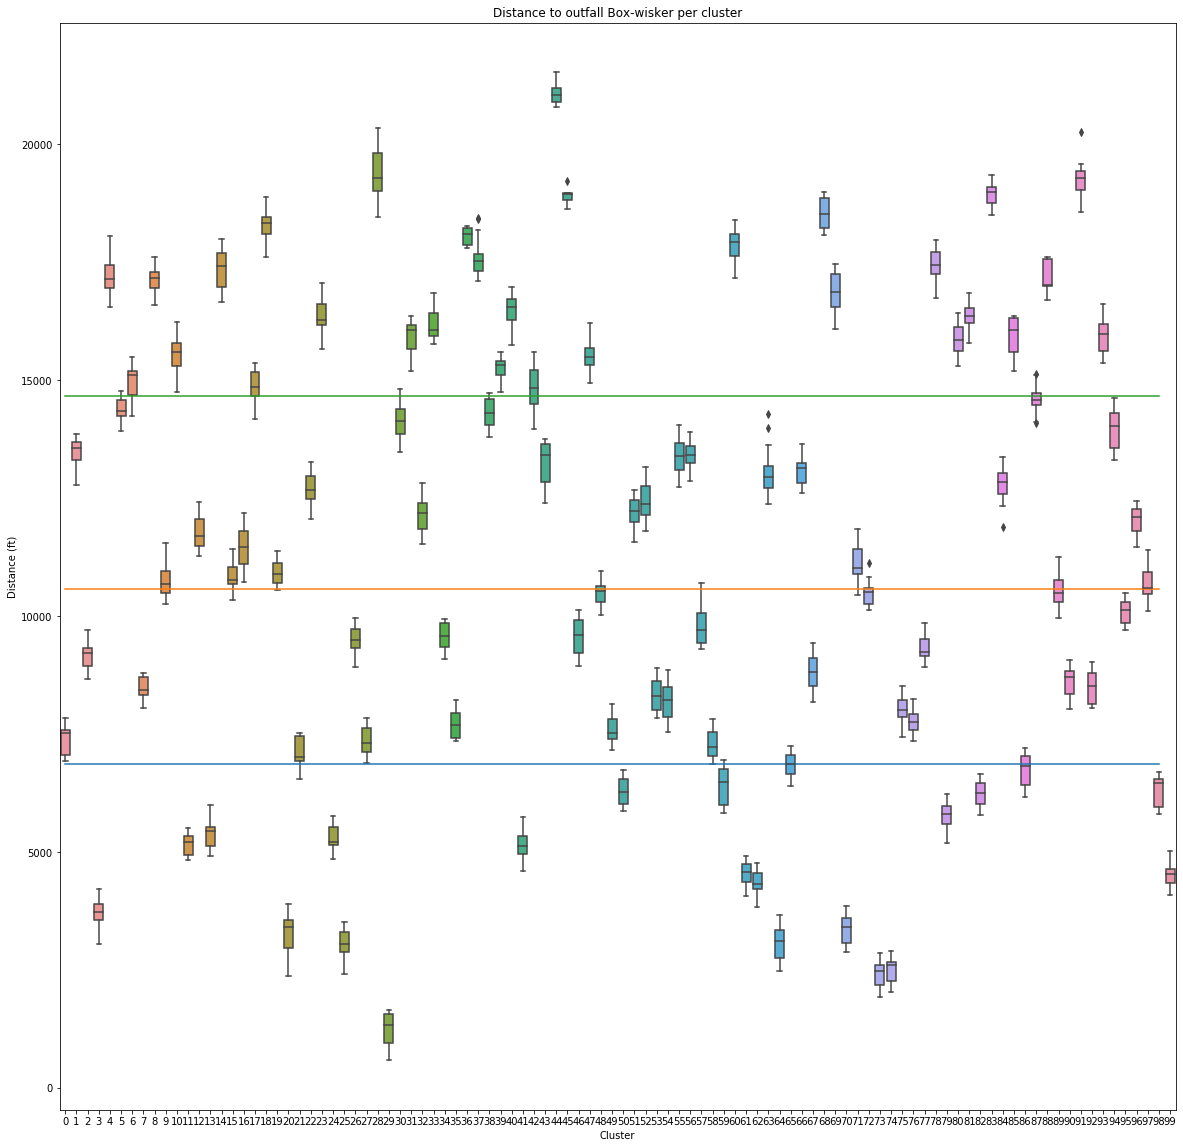

In [7]:
%matplotlib inline
distance= pd.read_csv('distance_to_centroid.txt', sep="\t")
distance=distance.set_index('subcatchment')
distance=distance.rename(columns={'NEAR_DIST':'Dist_to_outfall'})

plt.figure(figsize=(20,20))#frame
sns.boxplot(x='Cluster',y='Dist_to_outfall',data=distance)
l25=np.ones(99)*distance.Dist_to_outfall.quantile(0.25)
l50=np.ones(99)*distance.Dist_to_outfall.quantile(0.5)
l75=np.ones(99)*distance.Dist_to_outfall.quantile(0.75)
lb = [i for i in range(99)]
plt.plot(lb,l25)
plt.plot(lb,l50)
plt.plot(lb,l75)
plt.title('Distance to outfall Box-wisker per cluster')
plt.ylabel('Distance (ft)')

Spatially, the quartiles are interpreted as ratial distances to classify the clusters. Observe there are some clusters that fall can be clasified in two areas. The rule of thumb for classifying the clusters into sectors will be if the mean distance of the clusters falls witthin a sector, all the subcatchments belonging to that cluster will be classified in that sector, even if they are not strictly within it.


The radial thresholds we defined are:
Downstream: <= 6,860 ft
Middle-downstream: <= 10,571 ft
Middle-upstream: <= 14,672 ft
Upstream: > 14,672 ft

Observe that the furthest subcatchment is located in the eastern upper corner of the subcatchment, at a distance of 21,533 ft.

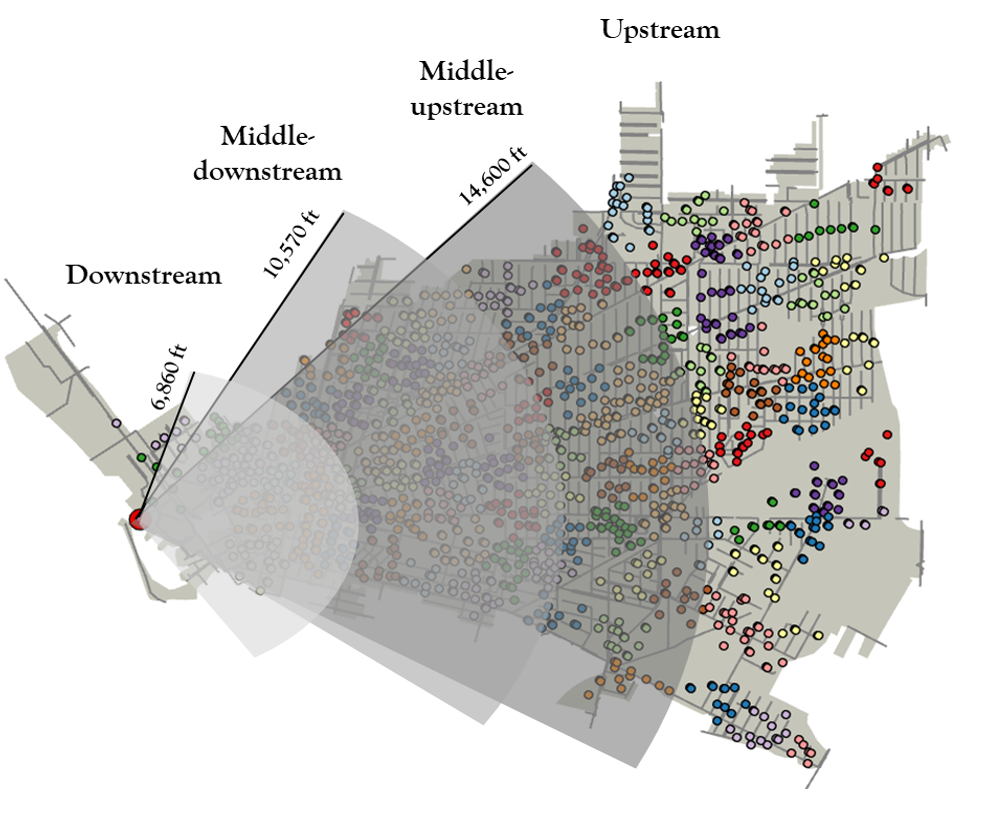

In [8]:
from IPython.display import Image
Image(filename='clusters_distance_to_outfall.png', width=700)

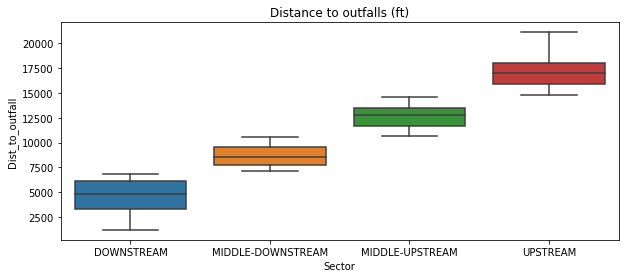

In [9]:
#Calculate the mean distance of each cluster 
mean_dist=distance.groupby('Cluster').agg({'Dist_to_outfall':'mean'})

#Add the rules for classification
mean_dist["Sector"]=np.where(mean_dist["Dist_to_outfall"] <= distance.Dist_to_outfall.quantile(0.25),"DOWNSTREAM",np.where(mean_dist["Dist_to_outfall"] <= distance.Dist_to_outfall.quantile(0.5),"MIDDLE-DOWNSTREAM",np.where(mean_dist["Dist_to_outfall"] <= distance.Dist_to_outfall.quantile(0.75),"MIDDLE-UPSTREAM","UPSTREAM")))

#make categorical the "Sector" column
mean_dist['Sector'] = pd.Categorical(mean_dist['Sector'], categories=
    ['DOWNSTREAM','MIDDLE-DOWNSTREAM','MIDDLE-UPSTREAM','UPSTREAM'],
    ordered=True)

plt.figure(figsize=(10,4))
sns.boxplot(x='Sector',y='Dist_to_outfall',data=mean_dist)#,hue='survived',
plt.title('Distance to outfalls (ft)')
plt.show()


In [10]:
characteristics= pd.read_csv('cluster100_characteristics.txt', sep="\t")
characteristics.head(3)
area_cluster=characteristics.groupby('Cluster').agg({'AREA':'sum'})
area_cluster=area_cluster.reset_index()
area_cluster.head(2)

,Cluster,AREA
0,0,5.393
1,1,8.519


In [11]:
#Merge both data sets
mean_dist=mean_dist.reset_index() #reset index to create a column of "Clusters" to merge
data_merged= data_w_clusters.merge(mean_dist,left_on='Cluster',right_on='Cluster',how='left')
#merge the characteristics of the subcatchments
data_merged= data_merged.merge(characteristics,left_on='Cluster',right_on='Cluster',how='left')
data_merged.drop(["X","Y","WIDTH","SLOPE","IMPERV"],axis=1).head(10)

,CX,CY,Cluster,Dist_to_outfall,Sector,NAME,AREA
0,1065831.751,1053773.253,74.0,2518.203333,DOWNSTREAM,SAimp_E-MH-3450-3,2.146
1,1065831.751,1053773.253,74.0,2518.203333,DOWNSTREAM,SAimp_6774b-7,0.147
2,1065831.751,1053773.253,74.0,2518.203333,DOWNSTREAM,SAimp_6774b-4,0.168
3,1065831.751,1053773.253,74.0,2518.203333,DOWNSTREAM,SAimp_6774b-6,0.339
4,1065831.751,1053773.253,74.0,2518.203333,DOWNSTREAM,SAimp_6774b-8,1.458
5,1065831.751,1053773.253,74.0,2518.203333,DOWNSTREAM,Parking_6774b-2,0.989
6,1065831.751,1053773.253,74.0,2518.203333,DOWNSTREAM,SAimp_6774b-2,0.331
7,1065831.751,1053773.253,74.0,2518.203333,DOWNSTREAM,Parking_6774b-5,1.028
8,1065831.751,1053773.253,74.0,2518.203333,DOWNSTREAM,SAimp_6774b-5,0.403
9,1066474.679,1052839.005,29.0,1214.007500,DOWNSTREAM,SAimp_E-MH-3450-2,3.480


## Two ways of creating scenarios
### Option 1: Creating a function that assigns the PP SWMM in the input file.
This option will require the execution of the .inps out of OSTRICH-SWMM.

In [15]:
#function to assign the PP in the input files
def assign_clusters_input_file(df,file_name):
#Prepare the text to be added in [LID USAGE]
    selection=[]
    PP_to_assign_last_cluster=df["area_ac"].iloc[-1]
    switch=0
    txt= ""

    for i in PP_ids: #the ID of each cluster in df
        selection=characteristics[(characteristics['Cluster']==i)] #extracts the subcatchments of each cluster
        print(selection)
        #if it is the last cluster, the area to be assigned is not all the area of the subctachment
        if i == PP_ids[-1]:
            for row in selection.iterrows(): 
                #if the subcatchment area is larger than the PP area to assign, then use all the subcatch area
                if row[1]['AREA']> PP_to_assign_last_cluster:
                    if PP_to_assign_last_cluster>0.01: #while there is still PP area to asign
                        txt+=row[1]['NAME'] + " " + 'Porous_Pavements' + " " + str(1)+ " " + str(math.floor(PP_to_assign_last_cluster*43560*100)/100) + " " + str(0)+ " " + str(0)+ " " + str(0)+ " " + str(0) + "\n"
                        PP_to_assign_last_cluster=0
                        break
                #otherwise, assign the PP that is left
                else:
                    txt+=row[1]['NAME'] + " " + 'Porous_Pavements' + " " + str(1)+ " " + str(math.floor(row[1]['AREA']*43560*100)/100) + " " + str(0)+ " " + str(0)+ " " + str(0)+ " " + str(0) + "\n"
                    PP_to_assign_last_cluster=PP_to_assign_last_cluster-row[1]['AREA']

        #otherwise, assign all the subcatchment area to PP
        else:
            pass
            for row in selection.iterrows():
                txt+=row[1]['NAME'] + " " + 'Porous_Pavements' + " " + str(1)+ " " + str(math.floor(row[1]['AREA']*43560*100)/100) + " " + str(0)+ " " + str(0)+ " " + str(0)+ " " + str(0) + "\n"

#Identifies the correct location to inject the Text in the input file.
    with open('BSA_Main_Model.inp') as f:
        counter=1
        datafile = f.readlines()
        for line in datafile:
            if '[LID_USAGE]' in line:
                SUBC=counter
            counter=counter+1    
    
    NEWfile = open(file_name, "w")
    LINEcounter=1       
    for line in datafile:
        NEWfile.write(line)
        if LINEcounter==SUBC+2: #two lines ahead [LID_USAGE], making space for headers
            NEWfile.write(txt)
        LINEcounter=LINEcounter+1

In [16]:
clusters_number=100 #number of clusters
iterations=2 #number of iterations= number of runs
random.seed(1234)
nsect=4 #number of sectors 
arr={}

for i in data_merged['Sector'].unique(): #iterating over the sectors
    for j in range(iterations): #number of iterations per sector
        PP_assigned=[] #create an empty list to store the PP area assigned
        PP_ids=[] #create an empty list to store the subcatchments id's to which PP area is assigned
        PP_to_assign=50 #area in acres to be assigned
        df_temp=data_merged[data_merged['Sector']==i] #extract a temporal dataframe with clusters in the sector i
        listclusters=list(df_temp.Cluster) #transform to a list
        
        while PP_to_assign>0: #while there is still PP are to asign
            current_clust=listclusters[random.randint(0, len(listclusters)-1)] #pick a cluster randomly
            listclusters.remove(current_clust) #remove the selected cluster from the list (to avoid repetition)
            #if the cluster area is larger than the PP area to assign, then use all the cluster area
            area_cl=area_cluster.AREA[current_clust]
            if area_cl> PP_to_assign:
                PP_assigned.append(PP_to_assign)
                PP_to_assign=0
            #otherwise, assign the PP that is left
            else:            
                PP_to_assign= PP_to_assign-area_cl
                PP_assigned.append(area_cl)
            PP_ids.append(current_clust)
        df3= pd.DataFrame(list(zip(PP_ids, PP_assigned)), columns =['cluster', 'area_ac'])

        file_name=f"sector_{str(i)}_it_{str(j)}.inp"
        #Run the function to create a new input file
        assign_clusters_input_file(df3,file_name)

     Cluster                  NAME            X            Y   AREA     WIDTH  \
343       50       Parking_11325-3  1072008.347  1053012.511  2.667  1161.745   
362       50    Parking_E-MH-19490  1072188.758  1052717.222  0.138    60.113   
364       50      SAimp_E-MH-19490  1072223.758  1052692.222  0.313    45.448   
365       50  Parking_E-node-546-2  1072226.994  1052512.569  0.192    83.635   
369       50    SAimp_E-node-546-2  1072261.994  1052487.569  0.258    37.462   
383       50   Parking_E-MH-4558-2  1072398.725  1053079.075  0.369   160.736   
385       50  Parking_E-node-546-1  1072429.942  1052469.747  0.663   288.803   
387       50     SAimp_E-MH-4558-2  1072433.725  1053054.075  0.453    65.776   
390       50     SAimp_E-MH-4558-1  1072464.185  1053389.925  0.193    28.024   
391       50    SAimp_E-node-546-1  1072464.942  1052444.747  0.261    37.897   
396       50     SAimp_E-node-1314  1072505.209  1052769.217  0.120    30.887   
408       50       Parking_1

     Cluster                  NAME            X            Y   AREA    WIDTH  \
49        70   Parking_E-MH-4680-1  1068801.458  1052836.164  0.777  338.461   
52        70     SAimp_E-MH-4680-1  1068836.458  1052811.164  0.302   43.850   
54        70   Parking_E-MH-4680-2  1068909.666  1052644.744  0.277  120.661   
64        70       SAimp_E-MH-6268  1069067.743  1053028.483  0.106   27.632   
67        70          Parking_9342  1069090.753  1052649.791  0.446  194.278   
68        70       SAimp_E-MH-4168  1069097.837  1053315.722  0.111   22.413   
70        70            SAimp_9342  1069125.753  1052624.791  0.261   40.014   
71        70     Parking_E-MH-4639  1069162.361  1052855.412  0.778  338.897   
72        70       SAimp_E-MH-4637  1069165.622  1053548.360  0.167   29.800   
73        70       SAimp_E-MH-4639  1069197.361  1052830.412  0.267   40.217   
75        70          Parking_9341  1069213.728  1052468.572  0.367  159.865   
77        70            SAimp_9341  1069

     Cluster                   NAME            X            Y   AREA  \
294       49  Parking_E-node-1502-2  1071617.565  1056120.687  0.724   
302       49    SAimp_E-node-1502-2  1071652.565  1056095.687  0.227   
304       49    Parking_E-MH-6109-4  1071675.309  1056475.622  0.142   
307       49      SAimp_E-MH-6109-4  1071710.309  1056450.622  0.249   
310       49  Parking_E-node-1502-1  1071748.349  1056689.562  0.321   
313       49    SAimp_E-node-1502-1  1071783.349  1056664.562  1.256   
320       49      Parking_E-MH-4163  1071825.205  1055987.385  0.300   
326       49    Parking_E-MH-6109-2  1071873.255  1056166.229  0.597   
329       49      Parking_E-MH-4176  1071908.008  1056751.179  0.281   
330       49      SAimp_E-MH-6109-2  1071908.255  1056141.229  0.140   
333       49        SAimp_E-MH-4176  1071943.008  1056726.179  0.232   
353       49      Parking_E-MH-8025  1072139.535  1056071.031  0.447   
359       49        SAimp_E-MH-8025  1072174.535  1056046.031  0

     Cluster                 NAME            X            Y   AREA    WIDTH  \
685       26         SAimp_6842-2  1075275.080  1049949.562  0.648   94.090   
701       26  Parking_E-MH-4375-2  1075466.005  1050153.247  0.230  100.188   
706       26    SAimp_E-MH-4375-2  1075501.005  1050128.247  0.108   16.763   
708       26  Parking_E-MH-4376-2  1075551.011  1050456.604  0.551  240.016   
710       26    SAimp_E-MH-4376-2  1075586.011  1050431.604  0.242   35.138   
720       26    Parking_E-MH-4272  1075690.323  1050066.203  0.184   80.150   
722       26       Parking_6842-4  1075715.978  1049443.283  0.131   57.064   
725       26         SAimp_6842-4  1075750.978  1049418.283  0.461   66.937   
726       26    SAimp_E-MH-4376-1  1075761.606  1050504.078  0.360   52.272   
728       26  Parking_E-MH-4264-2  1075778.410  1049907.613  0.296  128.938   
734       26    SAimp_E-MH-4264-2  1075813.410  1049882.613  0.319   46.319   
748       26    Parking_E-MH-4263  1075899.124  1049

     Cluster                    NAME            X            Y   AREA  \
787        9     Parking_E-MH-3442-1  1076338.495  1048498.167  1.606   
796        9       SAimp_E-MH-3442-1  1076373.495  1048473.167  0.475   
819        9       SAimp_E-MH-3442-2  1076600.811  1048649.726  0.127   
825        9      Parking_E-node-321  1076672.124  1048303.662  0.253   
832        9        SAimp_E-node-321  1076707.124  1048278.662  0.494   
833        9   Parking_E-node-2539-2  1076711.792  1049194.541  0.143   
834        9     SAimp_E-node-2539-2  1076746.792  1049169.541  1.235   
843        9         SAimp_E-MH-3661  1076822.493  1048596.145  0.168   
847        9  SAimp_E-ADDED-MH-14891  1076851.044  1048867.182  0.390   
861        9           Parking_SENEM  1076939.424  1048385.155  0.342   
864        9             SAimp_SENEM  1076974.424  1048360.155  0.520   
877        9           SAimp_12010-2  1077135.487  1048616.391  0.242   
920        9     Parking_E-MH-4081-1  1077543.569  

     Cluster                  NAME            X            Y   AREA    WIDTH  \
717       97           SAimp_14190  1075643.338  1055356.810  0.164   24.444   
718       97      SAimp_E-node-630  1075646.547  1055559.032  0.496   72.019   
723       97       SAimp_E-MH-5817  1075734.575  1055930.802  0.112   24.889   
732       97     Parking_E-MH-5893  1075805.654  1056114.167  0.299  130.244   
737       97         SAimp_11561-1  1075830.503  1055823.116  0.382   55.466   
742       97       SAimp_E-MH-5893  1075840.654  1056089.167  0.243   35.284   
747       97         SAimp_11561-2  1075894.273  1055871.438  0.864  125.453   
753       97   Parking_E-node-2397  1075949.046  1055575.774  0.203   88.427   
755       97     SAimp_E-node-2397  1075984.046  1055550.774  0.776  112.675   
769       97         Parking_11668  1076107.208  1054959.117  0.226   98.446   
774       97           SAimp_11668  1076142.208  1054934.117  2.005  291.126   
776       97       SAimp_E-MH-5807  1076

      Cluster               NAME            X            Y   AREA    WIDTH  \
1483       60        SAimp_12782  1083178.368  1054936.741  0.187   27.152   
1491       60        SAimp_12781  1083293.308  1055697.771  0.412   59.823   
1495       60        SAimp_12783  1083347.926  1055112.525  0.169   30.403   
1502       60    SAimp_E-MH-3811  1083482.266  1055413.918  0.574   83.345   
1504       60  SAimp_E-node-2251  1083526.830  1054995.801  0.321   46.609   
1523       60  Parking_E-MH-3812  1083668.970  1055774.909  0.561  244.372   
1529       60    SAimp_E-MH-3812  1083703.970  1055749.909  0.861  125.017   
1540       60  SAimp_E-node-2250  1083834.116  1055104.534  0.202   29.331   
1542       60    SAimp_E-MH-3962  1083876.471  1056167.351  0.111   16.117   
1544       60        SAimp_13208  1083881.563  1055873.385  0.109   16.722   
1546       60      SAimp_13201-1  1083893.916  1055534.028  0.246   35.719   
1548       60    SAimp_E-MH-3871  1083917.344  1054823.777  0.38

      Cluster               NAME            X            Y   AREA    WIDTH  \
1483       60        SAimp_12782  1083178.368  1054936.741  0.187   27.152   
1491       60        SAimp_12781  1083293.308  1055697.771  0.412   59.823   
1495       60        SAimp_12783  1083347.926  1055112.525  0.169   30.403   
1502       60    SAimp_E-MH-3811  1083482.266  1055413.918  0.574   83.345   
1504       60  SAimp_E-node-2251  1083526.830  1054995.801  0.321   46.609   
1523       60  Parking_E-MH-3812  1083668.970  1055774.909  0.561  244.372   
1529       60    SAimp_E-MH-3812  1083703.970  1055749.909  0.861  125.017   
1540       60  SAimp_E-node-2250  1083834.116  1055104.534  0.202   29.331   
1542       60    SAimp_E-MH-3962  1083876.471  1056167.351  0.111   16.117   
1544       60        SAimp_13208  1083881.563  1055873.385  0.109   16.722   
1546       60      SAimp_13201-1  1083893.916  1055534.028  0.246   35.719   
1548       60    SAimp_E-MH-3871  1083917.344  1054823.777  0.38

### Option 2: Creating a function that assigns the PP as input parameters to OSTRICH-SWMM

In [126]:
#function to assign the PP in ostIn.txt
def assign_clusters_ostIn(df):
    #Prepare the text to be added in [LID USAGE]
    selection=[]
    PP_to_assign_last_cluster=df["area_ac"].iloc[-1]
    switch=0
    dict_temp={}
    diccionarios_iteraciones=[]

    for i in PP_ids: #the ID of each cluster in df
        selection=characteristics[(characteristics['Cluster']==i)] #extracts the subcatchments of each cluster
        #if it is the last cluster, the area to be assigned is not all the area of the subctachment
        if i == PP_ids[-1]:
            for row in selection.iterrows(): 
                #if the subcatchment area is larger than the PP area to assign, then use all the subcatch area
                if row[1]['AREA']> PP_to_assign_last_cluster:
                    if PP_to_assign_last_cluster>0.01: #while there is still PP area to asign
                        dict_temp[str(row[1]['NAME'])]=math.floor(PP_to_assign_last_cluster*43560*100)/100
                        PP_to_assign_last_cluster=0
                        break
                #otherwise, assign the PP that is left
                else:
                    dict_temp[str(row[1]['NAME'])]=math.floor(row[1]['AREA']*43560*100)/100
                    PP_to_assign_last_cluster=PP_to_assign_last_cluster-row[1]['AREA']

        #otherwise, assign all the subcatchment area to PP
        else:
            for row in selection.iterrows():
                dict_temp[str(row[1]['NAME'])]=math.floor(row[1]['AREA']*43560*100)/100

    return(dict_temp)

In [129]:
#Identifies the correct location to inject the initial parameters.
with open('ostInZeros_cso014_.txt') as f:
    counter=0
    datafile = f.readlines()
    for line in datafile:
        counter=counter+1
        if 'BeginInitParams' in line:
            parameters=datafile[counter]
            values=datafile[counter+1]
            counter_to_inject=counter

param=pd.Series(parameters.split("\t"))
val=pd.Series(values.split("\t"))
init_param=pd.concat([param, val],axis=1)
init_param=init_param.rename(columns={0:'param',1:'iter1'})
init_param=init_param.set_index('iter1')

#Ver la ultima linea
#print(init_param.iloc[-1:,])

clusters_number=100 #number of clusters
iterations=100 #number of iterations= number of runs
random.seed(1234)
nsect=4 #number of sectors 
arr={}
diccionarios_temporales=[]
labels=[]

for i in data_merged['Sector'].unique(): #iterating over the sectors
    for j in range(iterations): #number of iterations per sector
        PP_assigned=[] #create an empty list to store the PP area assigned
        PP_ids=[] #create an empty list to store the subcatchments id's to which PP area is assigned
        PP_to_assign=50 #area in acres to be assigned
        df_temp=data_merged[data_merged['Sector']==i] #extract a temporal dataframe with clusters in the sector i
        listclusters=list(df_temp.Cluster) #transform to a list
        
        while PP_to_assign>0: #while there is still PP are to asign
            current_clust=listclusters[random.randint(0, len(listclusters)-1)] #pick a cluster randomly
            listclusters.remove(current_clust) #remove the selected cluster from the list (to avoid repetition)
            #if the cluster area is larger than the PP area to assign, then use all the cluster area
            area_cl=area_cluster.AREA[current_clust]
            if area_cl> PP_to_assign:
                PP_assigned.append(PP_to_assign)
                PP_to_assign=0
            #otherwise, assign the PP that is left
            else:            
                PP_to_assign= PP_to_assign-area_cl
                PP_assigned.append(area_cl)
            PP_ids.append(current_clust)
        df3= pd.DataFrame(list(zip(PP_ids, PP_assigned)), columns =['cluster', 'area_ac'])
        dict_temp=assign_clusters_ostIn(df3)
        diccionarios_temporales.append(dict_temp)
        labels.append(f'{i}_iter{j}')
    
#Extract info from dictionary and add to dataframe
cont=1
for diccionario in diccionarios_temporales:
    #df_tmp=pd.DataFrame.from_dict(diccionario, orient='index',columns=[f'area_it{cont}'])
    df_tmp=pd.DataFrame.from_dict(diccionario, orient='index',columns=[labels[cont-1]])
    init_param=init_param.merge(df_tmp,left_index=True,right_index=True,how='left').fillna(0)
    cont+=1
    
init_param_transp=init_param.T.drop('param')
arr_param = init_param_transp.to_numpy()

In [139]:
if os.path.exists("np.txt")==True : os.remove("np.txt") #erase the file if exists
np.savetxt('np.txt', init_param_transp.values,fmt='%d')